# BICS_ABM
Ethan Roubenoff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BICS_ABM import BICS_ABM, VaccineRule
import time
from joblib import Parallel, delayed
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, uniform, randint

/Users/eroubenoff/BICS_ABM/BICS_ABM.py:77: DtypeWarning: Columns (26,63,64,65,66,68,69,70,71,72,73,76,86,139,140,149,175,176,177,191,195,205,213,214,215,216,217,218,219,220,221,222,223,224,225,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  BICS = pd.read_csv("data/df_all_waves.csv")


## Quick, demonstrative example:

-1    660
 0    619
 1    555
 4    392
 2    375
 5    195
 3    177
 6     20
Name: vaccine_priority, dtype: int64
----------------------------------------
Parameters passed to simulation:
N_HH:            10000
GAMMA_MIN, _MAX: 48, 96
SIGMA_MIN, _MAX: 72, 168
BETA:            0.01
MU_VEC:          1e-05  0.0001  0.0001  0.001  0.001  0.001  0.01  0.1  0.1  
INDEX_CASES:     5
SEED:            4949
N_VAX_DAILY:     1500
VE1, VE2:        0.75, 0.95
VEW, VEBoost:    0.25, 0.95
ALPHA:           0.25
RHO:             0.9
ISOLATION_MULT.: 0.1
----------------------------------------
N vertices: 36644
N households: 10000
N household edges 61159
Index cases: 17154  4302  3847  11063  1851  
Day  127 Hour 23 | S: 12185 | E:     0 | Ic:     0 | Isc:     0 | R: 24317 | D:   142 | V1:     0 | V2:     0 | VW: 28735 | VBoost:     0 | Edge counts: Household: 61159 Work  Random      0


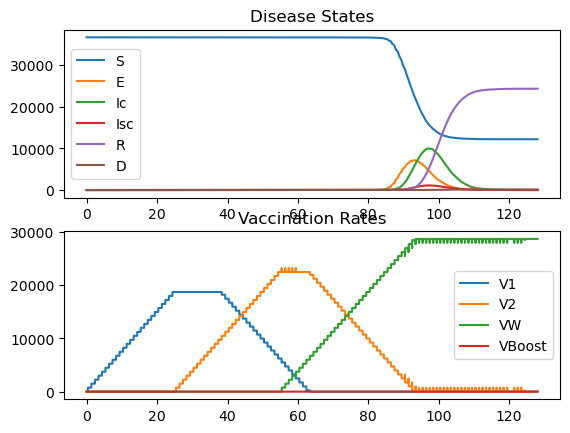

In [2]:
result = BICS_ABM( 
        N_HH = 10000,
        SEED = 4949, 
        RHO = 0.9,
        ALPHA = 0.25,
        BETA = 0.01,
        T0 = 60,
        ISOLATION_MULTIPLIER = 0.1, 
        N_VAX_DAILY = 1500,
        vax_rules = [
            VaccineRule("age > 80"),
            VaccineRule("age > 70"),
            VaccineRule("age > 60"),
            VaccineRule("age > 50", hesitancy = 0.5),
            VaccineRule("age > 40", hesitancy = 0.5),
            VaccineRule("age > 30", hesitancy = 0.5),
            VaccineRule(general = True, hesitancy = 0.5),
        ])

result.plot_trajectory()

In [ ]:
# Calculate the effective R0 as beta * average contacts per hour per person * average time infectious
0.01 * np.mean(result.n_edges)/result.S[0] * ((48+96)/2 + (72+168)/2)

In [ ]:
temp = BICS_ABM(N_HH = 10000, ISOLATION_MULTIPLIER = 0, INDEX_CASES = 6, BETA = 0.01,
         GAMMA_MIN = 48, GAMMA_MAX = 48, SIGMA_MIN = 96, SIGMA_MAX = 96, RHO = 1, ALPHA = 0)
temp.plot_trajectory()
plt.plot(temp.n_edges)

In [ ]:
temp = BICS_ABM(N_HH = 10000, ISOLATION_MULTIPLIER = 1, INDEX_CASES = 6, BETA = 0.01,
         GAMMA_MIN = 48, GAMMA_MAX = 48, SIGMA_MIN = 96, SIGMA_MAX = 96, RHO = 1, ALPHA = 0)
temp.plot_trajectory()
plt.plot(temp.n_edges)

## Another demonstrative example

Vary beta (probability of transmission from 0 to 0.1 in increments of 0.001. Run 10 simulations of each value for  beta. Plot the number of deaths against beta.

In [ ]:
beta_vec = np.arange(0, 0.1, 0.001)
beta_vec = beta_vec.repeat(10)
result_vec= np.zeros(beta_vec.shape) 

t = time.time()
for i, v in enumerate(beta_vec):
    print(i, "of", len(beta_vec), "sims", end = "\r")
    time.sleep(0) # To make carraige return work
    result = BICS_ABM(BETA = v, N_HH = 100, silent = True)
    result_vec[i] = result.D[-1] / (result.S[0] + result.E[0])
    
t = time.time() - t

print(len(beta_vec), "iterations took", t, "seconds")

In [ ]:
plt.scatter(beta_vec, result_vec*100)


# Speed test

Not whole necessary, but kind of fun. Seems like there is no benefit past 4 or 8 threads.


In [ ]:
if False:
    reps = np.arange(1, 100, 1)



    def multi_fn(i):
        """ Wrapper function for multiprocessing

        """

        result = BICS_ABM(
            N_HH = 1000, 
            silent = True, 
        )

        return 0


    tlist = list()
    jlist = [1, *range(2,20,2)]
    for jobs in jlist:
        t = time.time()
        Parallel(n_jobs=jobs, verbose = 10)(delayed(multi_fn)(v) for v in reps)
        t = time.time() - t
        tlist.append(t)

    plt.scatter(jlist, tlist)

# Main analysis

Run simulations that gradually decrease number of nonhousehold contacts required for priority access. Start at 30
and work down. Begin by assuming no asymptomatic transmission and 70% symptomatic rate, no isolation.


Run 10 simulations for each, and chart the number of deaths.

4 vaccine priorities: 
- No vax
- Equal priority vax
- Age priority
- Contact priority

4 transmission scenarios: 
- With pre/asymptomatic transmission and isolation
- No pre-symptomatic/asymptomatic transmission
- No isolation
- Vaccine roll-out happens at the same time as index cases
- Vaccine roll-out happens before index cases

In [6]:
# Generate all variable draws using LHS 
nsims = 100
sampler = LatinHypercube(21)
sample = sampler.random(nsims)

gamma_min_v = [int(randint.ppf(x, 0*24, 2*24)) for x in sample[:,0]] 
gamma_max_v = [int(randint.ppf(x, 2*24, 4*24)) for x in sample[:,1]] 
sigma_min_v = [int(randint.ppf(x, 3*24, 5*24)) for x in sample[:,2]] 
sigma_max_v = [int(randint.ppf(x, 5*24, 7*24)) for x in sample[:,3]] 
beta_v = [uniform.ppf(x, 0, .05) for x in sample[:,4]] 
alpha_v = [uniform.ppf(x, 0, .25) for x in sample[:,5]] 
rho_v = [uniform.ppf(x, .7, 1) for x in sample[:,6]] 
isomult_v = [uniform.ppf(x, .5, .5) for x in sample[:,7]] 

mu0_v = [uniform.ppf(x, 0.003, 0.005)/100 for x in sample[:,8]] 
mu1_v = [uniform.ppf(x, 0.003, 0.005)/100 for x in sample[:,9]] 
mu2_v = [uniform.ppf(x, 0.058, 0.078)/100 for x in sample[:,10]] 
mu3_v = [uniform.ppf(x, 0.20, 0.26)/100 for x in sample[:,11]] 
mu4_v = [uniform.ppf(x, 0.66, 0.87)/100 for x in sample[:,12]] 
mu5_v = [uniform.ppf(x, 0.66, 0.87)/100 for x in sample[:,13]] 
mu6_v = [uniform.ppf(x, 2.1, 3.0)/100 for x in sample[:,14]] 
mu7_v = [uniform.ppf(x, 6.9, 10.4)/100 for x in sample[:,15]] 
mu8_v = [uniform.ppf(x, 21.8, 36.6)/100 for x in sample[:,16]] 

ve1_v = [uniform.ppf(x, 0.65, 0.75) for x in sample[:,17]]
ve2_v = [uniform.ppf(x, 0.85, 0.95) for x in sample[:,18]]
vew_v = [uniform.ppf(x, 0.25, 0.55) for x in sample[:,19]]
veb_v = [uniform.ppf(x, 0.65, 0.75) for x in sample[:,20]]

In [3]:
t = time.time()


def multi_fn(i):
    """ Wrapper function for multiprocessing
    
    """
    
    params = {
        "N_HH" : 1000, 
        "GAMMA_MIN" : gamma_min_v[i],
        "GAMMA_MAX" : gamma_max_v[i],
        "SIGMA_MIN" : sigma_min_v[i],
        "SIGMA_MAX" : sigma_max_v[i],
        "BETA" : beta_v[i],
        "ALPHA" : alpha_v[i], 
        "RHO" : rho_v[i], 
        "ISOLATION_MULTIPLIER" : isomult_v[i],
        "MU_VEC" : [
            mu0_v[i],
            mu1_v[i],
            mu2_v[i],
            mu3_v[i],
            mu4_v[i],
            mu5_v[i],
            mu6_v[i],
            mu7_v[i],
            mu8_v[i]],
        "silent" : True,
        "T0" : 0,
        "INDEX_CASES": 5,
        "SEED" : i,
        "VE1" : ve1_v[i],
        "VE2" : ve2_v[i],
        "VEW" : vew_v[i],
        "VEBOOST" : veb_v[i],
    }
    
    result_none = BICS_ABM(
        **params,
        vax_rules = [VaccineRule(general = False)]
    )
    
    result_general = BICS_ABM(
        **params,
        vax_rules = [VaccineRule(general = True)]
    )
    
    result_age = BICS_ABM(
        **params,
        vax_rules = [
            VaccineRule("age > 80"),
            VaccineRule("age > 70"),
            VaccineRule("age > 60"),
            VaccineRule("age > 50"),
            VaccineRule("age > 30"),
            VaccineRule("age > 20"),
            VaccineRule(general = True)
        ]
    )
    
    result_cc = BICS_ABM(
        **params,
        vax_rules = [
            VaccineRule("num_cc_nonhh > 30"),
            VaccineRule("num_cc_nonhh > 25"),
            VaccineRule("num_cc_nonhh > 20"),
            VaccineRule("num_cc_nonhh > 15"),
            VaccineRule("num_cc_nonhh > 10"),
            VaccineRule("num_cc_nonhh > 5"),
            VaccineRule("num_cc_nonhh > 4"),
            VaccineRule("num_cc_nonhh > 3"),
            VaccineRule("num_cc_nonhh > 2"),
            VaccineRule("num_cc_nonhh > 1"),
            VaccineRule(general = True)
        ]
    )
    
    return {
        'none_d': result_none.D[-1] / (result_none.S[0] + result_none.E[0]),
        'none_r': result_none.R[-1] / (result_none.S[0] + result_none.E[0]),
        'general_d': result_general.D[-1] / (result_general.S[0] + result_general.E[0]),
        'general_r': result_general.R[-1] / (result_general.S[0] + result_general.E[0]),
        'age_d': result_age.D[-1] / (result_age.S[0] + result_age.E[0]),
        'age_r': result_age.R[-1] / (result_age.S[0] + result_age.E[0]),
        'cc_d': result_cc.D[-1] / (result_cc.S[0] + result_cc.E[0]),
        'cc_r': result_cc.R[-1] / (result_cc.S[0] + result_cc.E[0]),
    }
    
    
# 10 is about the efficiency limit-- 2400 cycles will take about 2 mins
result_vec = Parallel(n_jobs=4, verbose = 10, prefer="threads")(delayed(multi_fn)(v) for v in range(nsims))
    
    
t = time.time() - t

print(len(result_vec), "iterations took", t, "seconds")


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Day   98 Hour 12 | S:  1157 | E:    78 | Ic:   162 | Isc:     0 | R:  2265 | D:    36 | V1:    48 | V2:  1500 | VW:  2150 | VBoost:     0 | Edge counts: Household:  1782 Work  Random   4020

Day   72 Hour 13 | S:   790 | E:     0 | Ic:     3 | Isc:     0 | R:  2792 | D:    52 | V1:     0 | V2:     0 | VW:  3636 | VBoost:     0 | Edge counts: Household:  1853 Work  Random   4050

Day   26 Hour 14 | S:  3695 | E:     0 | Ic:     0 | Isc:     0 | R:     7 | D:     0 | V1:  1250 | V2:  1500 | VW:   900 | VBoost:     0 | Edge counts: Household:  6207 Work  Random      0


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   58.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.1min


100 iterations took 545.1848587989807 seconds


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.1min finished


In [4]:
result_df = pd.DataFrame(result_vec)
result_df

,none_d,none_r,general_d,general_r,age_d,age_r,cc_d,cc_r
0,0.009179,0.461663,0.000000,0.001891,0.007563,0.448406,0.001351,0.205835
1,0.011239,0.781798,0.008498,0.780428,0.008772,0.807292,0.009046,0.765351
2,0.011087,0.733640,0.014073,0.712043,0.014073,0.609472,0.010014,0.494181
3,0.014297,0.768491,0.012648,0.781413,0.010448,0.662359,0.002750,0.309321
4,0.006983,0.654190,0.008659,0.589106,0.000279,0.003631,0.004190,0.313966
...,...,...,...,...,...,...,...,...
95,0.009338,0.431750,0.005493,0.475419,0.000275,0.004944,0.005493,0.273002
96,0.009174,0.537507,0.009976,0.605015,0.010523,0.468430,0.004857,0.420669
97,0.000000,0.004276,0.000000,0.002672,0.000000,0.006948,0.000000,0.001603
98,0.008280,0.515224,0.000267,0.008280,0.005876,0.520566,0.004274,0.226229


In [5]:
# For each sim, figure out which strategy had lowest death and infection rates

print(result_df.filter(like="_d").idxmin(axis=1).value_counts())
print(result_df.filter(like="_r").idxmin(axis=1).value_counts())


cc_d         38
none_d       29
age_d        19
general_d    14
dtype: int64
cc_r         44
age_r        25
none_r       17
general_r    14
dtype: int64


It appears that there is really not any advantage to prioritizing by degree

In [ ]:
result = BICS_ABM(
    # 1000 HHs, approx 3000 people, and 10% chance of transmission
    N_HH = 1000, BETA = 0.01,
    # No presymptomatic transmission, all cases are symptomatic
    ALPHA = 0, RHO = 1, 
    # No isolation
    ISOLATION_MULTIPLIER = 1,
    silent = True , 
    vax_rules = [
        VaccineRule("num_cc_nonhh > 10") 
    ]
)

In [ ]:
result.plot_trajectory()

## Q2: What it index cases come after vaccines have been distributed?

In [ ]:
cc_min = np.arange(25, 1, -1)
cc_min = cc_min.repeat(10)

t = time.time()


def multi_fn(i):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        # 1000 HHs, approx 3000 people, and 10% chance of transmission
        N_HH = 1000, BETA = 0.005,
        # No presymptomatic transmission, all cases are symptomatic
        ALPHA = 0, RHO = 1, 
        # No isolation
        ISOLATION_MULTIPLIER = 1,
        T0 = 60,
        silent = True , 
        vax_rules = [
            VaccineRule("num_cc_nonhh > " + str(i)) 
        ]
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
# 10 is about the efficiency limit-- 2400 cycles will take about 2 mins
result_vec = Parallel(n_jobs=8, verbose = 10, prefer="threads")(delayed(multi_fn)(v) for v in cc_min)
    
    
t = time.time() - t

print(len(cc_min), "iterations took", t, "seconds")


In [ ]:

fig, ax = plt.subplots(2)
ax[0].scatter(cc_min, [x[0] for x in result_vec])
ax[1].scatter(cc_min, [x[1] for x in result_vec])

# Sensitivity tests

beta: 0.0001 to 0.1

rho (probability of clinical): 0 to 1

alpha (relative infectiousness of pre and asymptomatic): 0 to 1

isolation multiplier: 0 to 1

In [ ]:
# beta vec with no asymptomatic transmission
beta_vec = np.arange(0.001, 0.1 , 0.001)
beta_vec = beta_vec.repeat(10)

t = time.time()


def multi_fn(beta):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        ALPHA = 0,
        RHO = 1,
        N_HH = 1000, BETA = beta, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(v) for v in beta_vec)
    
    
t = time.time() - t

print(len(beta_vec), "iterations took", t, "seconds")



In [ ]:


fig, ax = plt.subplots(2)
ax[0].scatter(beta_vec, [x[0] for x in result_vec])
ax[1].scatter(beta_vec, [x[1] for x in result_vec])

# Jointly vary the isolation multiplier and the proportion of symptomatic cases

In [ ]:
isomult_vec = np.arange(0, 1, 0.1)
rho_vec = np.arange(0, 1, 0.1)
isomult_vec, rho_vec = np.meshgrid(isomult_vec, rho_vec)
isomult_vec = isomult_vec.flatten().repeat(10)
rho_vec = rho_vec.flatten().repeat(10)


t = time.time()


def multi_fn(i, r):
    """ Wrapper function for multiprocessing
    
    """
    
    result = BICS_ABM(
        RHO = r,
        ISOLATION_MULTIPLIER = i, 
        N_HH = 1000, BETA = 0.01, 
        silent = True, 
        N_VAX_DAILY = 0
    )
    
    return (result.R[-1] / (result.S[0] + result.E[0]), result.D[-1] / (result.S[0] + result.E[0]))
    
    
result_vec = Parallel(n_jobs=8, verbose = 10)(delayed(multi_fn)(*x) for x in zip(isomult_vec, rho_vec))
    
    
t = time.time() - t

print(len(result_vec), "iterations took", t, "seconds")



In [ ]:
dv = np.array([x[0] for x in result_vec]).reshape((10,10,10))
iv = np.array([x[1] for x in result_vec]).reshape((10,10,10))

In [ ]:
plt.imshow(iv, extent = [0,1,0,1])
plt.title("% Of population infected")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()

In [ ]:
plt.imshow(dv, extent = [0,1,0,1])
plt.title("% Of population dead")
plt.xlabel("Isolation Multiplier")
plt.ylabel("Proportion of cases that are clinical")
plt.show()